<div style="border: 1px solid black">
<b><center><font size="4">Mini Projecto 01</font></center></b>

</div>

**Notebook base on**: [Ricardo Campos](https://www.di.ubi.pt/~rcampos)<br>
**Notebook Developed by**: Rene Jerez<br>
**email:**  rene.jerez@ubi.pt<br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span>
<a href="#Tarefa 1" data-toc-modified-id="Tarefa 1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tarefa 1</a></span><ul class="toc-item"><li><span>
<a href="#100 ficheiros" data-toc-modified-id="100 ficheiros-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>100 ficheiros</a></span></li><li><span>
<a href="#Guardar json" data-toc-modified-id="Guardar json-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Guardar json</a></span></li><li><span>
<a href="#Carregar json" data-toc-modified-id="Carregar json-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Carregar json</a></span></li><li><span>
<a href="#Imprimir 5 json" data-toc-modified-id="Imprimir 5 json-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Imprimir 5 json</a></span></li><li><span>
<a href="#Nuvem de Palavras" data-toc-modified-id="Nuvem de Palavras-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Nuvem de Palavras</a></span></li></ul></li>
<li><span>
<a href="#Tarefa 2" data-toc-modified-id="Tarefa 2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tarefa 2</a></span><ul class="toc-item"><li><span>
<a href="#Wikipedia imagens" data-toc-modified-id="Wikipedia imagens-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Wikipedia imagens</a></span></li></ul></li>
<li><span>
<a href="#Tarefa 3" data-toc-modified-id="Tarefa 3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tarefa 3</a></span><ul class="toc-item"><li><span>
<a href="#API Search" data-toc-modified-id="API Search-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>API Search</a></span></li><li><span>
<a href="#Guardar dinamicamente" data-toc-modified-id="Guardar dinamicamente-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Guardar dinamicamente</a></span></li><li><span>
<a href="#Imprimir 5 json" data-toc-modified-id="Imprimir 5 json-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Imprimir 5 json</a></span></li><li><span>
<a href="#Prêmio Arquivo PT" data-toc-modified-id="Prêmio Arquivo PT-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Prêmio Arquivo PT</a></span></li></ul></li>



</div>

# Tarefa 1

 Familiarização com a obtenção de dados a partir de ficheiros pdf

1. Reúna um conjunto aproximado de 100 ficheiros em formato pdf relacionados com
uma temática à sua escolha (e.g., artigos científicos; documentos do parlamento
europeu; patentes; programas eleitorais; etc). Proceda à extração do texto de cada
ficheiro com recurso a bibliotecas Python.

In [121]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import json
import pprint
from openai import OpenAI

In [37]:
# The URL of the page containing the links
page_url = 'https://www.ubi.pt/Pessoas'

# Fetch the content of the page
response = requests.get(page_url)
page_content = response.content

# Parse the page content using BeautifulSoup
soup = BeautifulSoup(page_content, 'html.parser')

# Find all links in the page (assuming they are contained in <a> tags)
links = soup.find_all('a')

# Create a list to hold your links and texts
link_table = []

# Loop through all found <a> tags
for link in links:
    href = link.get('href')  # Extract the href attribute (the URL)

    # Skip fragment identifiers and ensure the URL is complete
    if href and not href.startswith('#'):
        # Optional: Concatenate with the base URL if href is a relative URL
        if not href.startswith('http'):
            href = requests.compat.urljoin(page_url, href)

        # Store the link and an empty string for the text in the table
        link_table.append([href, ""])

# Convert the list to a DataFrame for easier handling
df = pd.DataFrame(link_table, columns=['Link', 'Text'])

# Filter for links containing 'Pessoa'
df = df[df['Link'].str.contains('Pessoa', na=False)]

# Remove duplicate links
df.drop_duplicates(subset='Link', inplace=True)


# Initialize columns name and image
df['ColunaNome'] = "Not found"
df['Photo'] = "Not found"

# Now iterate over the DataFrame, access each link, and fetch the text, Name and image url
for index, row in df.iterrows():
    link_url = row['Link']

    try:
        # Fetch the content of the linked page
        linked_page_response = requests.get(link_url)
        linked_page_content = linked_page_response.content

        # Parse the linked page
        linked_soup = BeautifulSoup(linked_page_content, 'html.parser')

        # Extract just content from a person without garbage
        specific_div = linked_soup.find('div', id="ConteudoHolder_LV_Detalhe_Pessoa_Panel_Visibilidade_0")
        # Extract text from the specific div, if it exists
        if specific_div:
            text = specific_div.get_text(separator=' ', strip=True)
        else:
            text = "Specific div not found."
        # Update the 'Text' column in the DataFrame with the extracted text
        df.at[index, 'Text'] = text

        # Extract the person name
        coluna_nome_elements = linked_soup.find_all(class_="colunaNome")
        # Extract text from these elements, if they exist
        if coluna_nome_elements:
            coluna_nome_texts = [elem.get_text(separator=' ', strip=True) for elem in coluna_nome_elements]
            # Join all found texts into a single string (or handle as you see fit)
            coluna_nome_text = ' | '.join(coluna_nome_texts)
        else:
            coluna_nome_text = "colunaNome elements not found."
        # Update the 'ColunaNome' column in the DataFrame with the extracted text
        df.at[index, 'ColunaNome'] = coluna_nome_text

        # Find the first element with class 'blkFicheiro ficheiroImagem' and extract the 'src' of the img tag
        photo_element = linked_soup.find(class_="blkFicheiro ficheiroImagem")
        if photo_element and photo_element.find('img'):
            photo_src = photo_element.find('img')['src']
            # Optional: Concatenate with the base URL if 'src' is a relative URL
            if not photo_src.startswith('http'):
                photo_src = requests.compat.urljoin(link_url, photo_src)
        else:
            photo_src = "Photo not found."
        # Update the 'Photo' column in the DataFrame with the photo URL
        df.at[index, 'Photo'] = photo_src

    except requests.exceptions.RequestException as e:
        # Handle exceptions like missing schema, connection errors, etc.
        print(f"Error fetching {link_url}: {e}")
        df.at[index, 'Text'] = "Error fetching content."
        df.at[index, 'ColunaNome'] = "Error fetching content."
        df.at[index, 'Photo'] = "Error fetching content."

    # Be mindful of the website's policy on automated requests and add a delay if necessary


In [46]:
#remove the first link because is a root of Pessoas page
df = df.iloc[1:]

In [97]:
# From text extract info such as Cargo, Unidades Curriculares, Artigos and Nota Biografica
def split_text(text):
    # Split the text based on the specified headings
    parts = re.split(r"(Sector  — Cargos/Funções|Unidades Curriculares|Contactos|Artigo em conferência/Conference paper|Nota Biográfica)", text)

    # Initialize a dictionary to hold the split parts
    split_parts = {'Sector_Cargos': '', 'Unidades_Curriculares': '','Contactos': '', 'Artigo_Conferencia': '', 'Nota_Biografica': ''}

    for i in range(1, len(parts), 2):
        if parts[i].startswith('Sector  — Cargos/Funções'):
            split_parts['Sector_Cargos'] = parts[i + 1]
        elif parts[i].startswith('Unidades Curriculares'):
            split_parts['Unidades_Curriculares'] = parts[i + 1]
        elif parts[i].startswith('Contactos'):
            split_parts['Contactos'] = parts[i + 1]    
        elif parts[i].startswith('Artigo em conferência/Conference paper'):
            split_parts['Artigo_Conferencia'] = parts[i + 1]
        elif parts[i].startswith('Nota Biográfica'):
            split_parts['Nota_Biografica'] = parts[i + 1]

    return pd.Series(split_parts)

# Apply the function to the 'Text' column and split the results into separate columns
split_columns = df['Text'].apply(split_text)
df = pd.concat([df, split_columns], axis=1)

# Now 'df' has four new columns: 'Sector_Cargos', 'Unidades_Curriculares', 'Artigo_Conferencia', and 'Nota_Biografica'


In [98]:
df.head(10)

Link  \
225      https://www.ubi.pt/Pessoa/abel.abejas   
227         https://www.ubi.pt/Pessoa/ajpgomes   
229           https://www.ubi.pt/Pessoa/abilio   
231  https://www.ubi.pt/Pessoa/adelaide.santos   
233             https://www.ubi.pt/Pessoa/amaa   
235          https://www.ubi.pt/Pessoa/aamaral   
237  https://www.ubi.pt/Pessoa/adelino.caetano   
239            https://www.ubi.pt/Pessoa/amssg   
241              https://www.ubi.pt/Pessoa/aos   
243  https://www.ubi.pt/Pessoa/freitas.azevedo   

                                                  Text  \
225  Sector  — Cargos/Funções Departamento de Ciênc...   
227  Sector  — Cargos/Funções Departamento de Infor...   
229  Sector  — Cargos/Funções Departamento de Engen...   
231  Sector  — Cargos/Funções Contabilidade e Tesou...   
233  Sector  — Cargos/Funções Divisão de Aprovision...   
235  Sector  — Cargos/Funções Departamento de Ciênc...   
237  Sector  — Cargos/Funções ST - Área de Manutenç...   
239  Sector  — Cargos/Funções Departamento de Ciênc...   
241  Sector  — Cargos/Funções Departamento de Ciênc...   
243  Sector  — Cargos/Funções NECE - Research Cente...   

                                            ColunaNome  \
225          Abel Garcia Abejas Assistente Convidado/a   
227   Abel João Padrão Gomes Professor/a Catedrático/a   
229  Abílio Manuel Pereira da Silva Professor/a Ass...   
231           Adelaide João Fonseca Vale Mendes Santos   
233   Adélia Maria Assis de Abrunhosa Chefe de Divisão   
235  Adelino Constantino Costa Amaral Assistente Co...   
237    Adelino de Jesus Caetano Assistente Operacional   
239  Adriana Manuela de Sousa e Silva Gonçalves Ass...   
241   Adriana Oliveira dos Santos Professor/a Auxiliar   
243                         Adriano Freitas de Azevedo   

                                                 Photo  \
225  https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg   
227   https://www.ubi.pt/Ficheiros/Pessoas/902/902.jpg   
229   https://www.ubi.pt/Ficheiros/Pessoas/689/689.jpg   
231                                   Photo not found.   
233   https://www.ubi.pt/Ficheiros/Pessoas/814/814.jpg   
235  https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg   
237  https://www.ubi.pt/Ficheiros/Pessoas/1703/1703...   
239  https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg   
241  https://www.ubi.pt/Ficheiros/Pessoas/3070/3070...   
243  https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg   

                                         Sector_Cargos  \
225   Departamento de Ciências Médicas — Docente do...   
227   Departamento de Informática — Docente do Depa...   
229   Departamento de Engenharia Eletromecânica — D...   
231   Contabilidade e Tesouraria — Funcionário/a no...   
233   Divisão de Aprovisionamento e Património — Ch...   
235   Departamento de Ciências Médicas — Docente do...   
237   ST - Área de Manutenção e Qualidade — Funcion...   
239   Departamento de Ciências Médicas — Docente do...   
241   Departamento de Ciências Médicas — Docente do...   
243   NECE - Research Center for Business Sciences ...   

                                 Unidades_Curriculares  \
225                    A Arte da Medicina (15099)2023    
227   Tecnologias de Jogos de Vídeo (13828)2023 Com...   
229   Materiais de Construção Aeroespacial (10368)2...   
231                                                      
233                                                      
235                                                      
237                                                      
239                                                      
241   Farmácia Galénica e Tecnologia Farmacêutica (...   
243                                                      

                                             Contactos  \
225                                 abel÷abejasðubi÷pt   
227     ajpgomesðubi÷pt 275242086 1606 CienciaVitae.pt   
229   abilioðubi÷pt 275242050 275329926 3926 3929 C...   
231                        adelaide÷santosðubi÷pt 2806   
233   

2. Guarde os conteúdos num ficheiro JSON adotando uma estrutura de dados apropriada
com vista a guardar todos os dados relevantes obtidos. Por exemplo, no caso de um
programa eleitoral, seria adequado guardar o nome do partido político, o líder do
partido à data da eleição, a designação da eleição, a data da eleição, o texto, assim
como outros elementos relevantes extraídos a partir da aplicação de ferramentas de
NLP ao texto, nomeadamente, palavras-relevantes, entidades (NER – named entity
recognition), datas e outras que achar adequadas. Seja criativo.


In [99]:
file_name = "ubi.json"

# Convert the DataFrame to a list of dictionaries
data = df.to_dict(orient='records')

# Convert the list of dictionaries to a JSON string with ensure_ascii=False
json_str = json.dumps(data, ensure_ascii=False, indent=4)

with open(file_name, "w", encoding='utf-8') as outfile:
    outfile.write(json_str)

3. Carregue o ficheiro JSON (anteriormente criado) para o seu ambiente de programação

In [100]:
file_name = "ubi.json"

with open(file_name, "r") as readfile:
    data = json.load(readfile)

#Impressao com recurso ao pretty print - mais entendivel
import pprint
pprint.pprint(data)

[{'Artigo_Conferencia': '',
  'ColunaNome': 'Abel Garcia Abejas Assistente Convidado/a',
  'Contactos': ' abel÷abejasðubi÷pt',
  'Link': 'https://www.ubi.pt/Pessoa/abel.abejas',
  'Nota_Biografica': '',
  'Photo': 'https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg',
  'Sector_Cargos': ' Departamento de Ciências Médicas — Docente do '
                   'Departamento de Ciências Médicas ',
  'Text': 'Sector  — Cargos/Funções Departamento de Ciências Médicas — Docente '
          'do Departamento de Ciências Médicas Unidades Curriculares A Arte da '
          'Medicina (15099)2023 Contactos abel÷abejasðubi÷pt',
  'Unidades_Curriculares': ' A Arte da Medicina (15099)2023 '},
 {'Artigo_Conferencia': '',
  'ColunaNome': 'Abel João Padrão Gomes Professor/a Catedrático/a',
  'Contactos': ' ajpgomesðubi÷pt 275242086 1606 CienciaVitae.pt',
  'Link': 'https://www.ubi.pt/Pessoa/ajpgomes',
  'Nota_Biografica': '',
  'Photo': 'https://www.ubi.pt/Ficheiros/Pessoas/902/902.jpg',
  'Sector_Cargos': ' 

' CICS - Centro de Investigação em Ciências da Saúde — '
                   'Investigador/a CICS - Health Sciences Research Center '
                   'Publicações Científicas Mais Recentes (Informação '
                   'importada da plataforma CiênciaVitae ) Artigo em '
                   'revista/Journal article Cabral, Cátia S.D.; de Melo-Diogo, '
                   'Duarte; Ferreira, Paula; Moreira, André F.; Correia, '
                   'Ilídio J. "Reduced graphene oxide-reinforced tricalcium '
                   'phosphate/gelatin/chitosan light-responsive scaffolds for '
                   'application in bone regeneration". International Journal '
                   'of Biological Macromolecules (2024) url Lima-Sousa, Rita; '
                   'Melo, Bruna L.; Mendonça, António G.; Correia, Ilídio J.; '
                   'de Melo-Diogo, Duarte. "Hyaluronic acid-functionalized '
                   'graphene-based nanohybrids for targeted breast cancer '
                  

4. Imprima o conteúdo do ficheiro JSON, restrito aos 5 primeiros registos.

In [101]:
file_name = "ubi.json"

with open(file_name, "r") as readfile:
    data = json.load(readfile)

#Impressao com recurso ao pretty print - mais entendivel
if isinstance(data, list) and len(data) > 0:
    pprint.pprint(data[:5])
else:
    print("JSON structure is not a list or is empty.")

[{'Artigo_Conferencia': '',
  'ColunaNome': 'Abel Garcia Abejas Assistente Convidado/a',
  'Contactos': ' abel÷abejasðubi÷pt',
  'Link': 'https://www.ubi.pt/Pessoa/abel.abejas',
  'Nota_Biografica': '',
  'Photo': 'https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg',
  'Sector_Cargos': ' Departamento de Ciências Médicas — Docente do '
                   'Departamento de Ciências Médicas ',
  'Text': 'Sector  — Cargos/Funções Departamento de Ciências Médicas — Docente '
          'do Departamento de Ciências Médicas Unidades Curriculares A Arte da '
          'Medicina (15099)2023 Contactos abel÷abejasðubi÷pt',
  'Unidades_Curriculares': ' A Arte da Medicina (15099)2023 '},
 {'Artigo_Conferencia': '',
  'ColunaNome': 'Abel João Padrão Gomes Professor/a Catedrático/a',
  'Contactos': ' ajpgomesðubi÷pt 275242086 1606 CienciaVitae.pt',
  'Link': 'https://www.ubi.pt/Pessoa/ajpgomes',
  'Nota_Biografica': '',
  'Photo': 'https://www.ubi.pt/Ficheiros/Pessoas/902/902.jpg',
  'Sector_Cargos': ' 

5. Crie uma nuvem de palavras a partir dos textos coletados. Seja criativo. Por exemplo,
crie diferentes word clouds se tiver mais do que um período de tempo. 

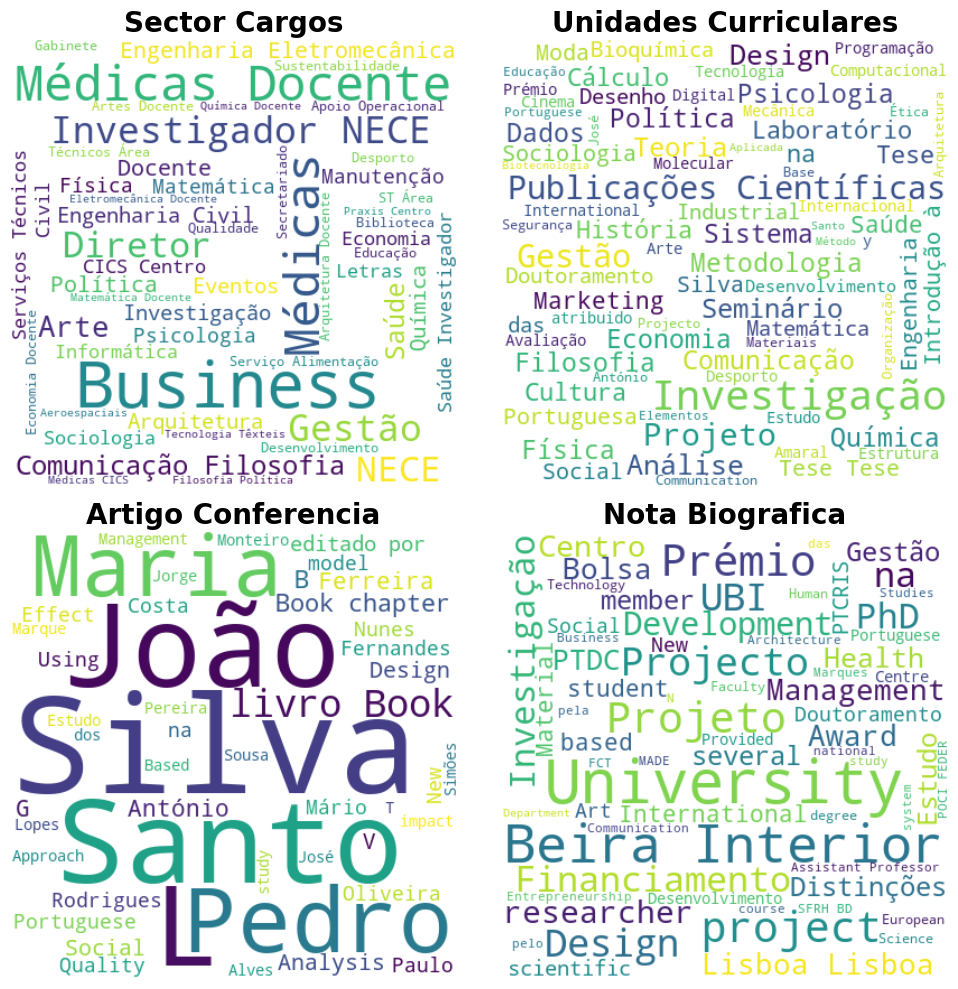

In [120]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Define your custom list of stopwords to exclude
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['Research','de', 'Ciência','CienciaVitae','CiênciaVitae', 'Departamento', 'Ciências',
                          'Plataforma','e', 'II', 'Informação', 'Incorporada', 'Recentes', 'Publicado', 
                         'url', 'Portugal', 'Revista', 'Journal','em','da','pt', 'Funcionário', 'Faculdade',
                         'curso', 'S', 'Center', 'Sciences', 'Capítulo', 'importada', 'article', 'Mais', 'Info', 'III',
                         'P','M','J','U','F','Artigo', 'editado por', 'D', 'Autor', 'Correspondente', 'Concluído', 'Universidade',
                         'para', 'C', 'O'])

columns = ["Sector_Cargos", "Unidades_Curriculares", "Artigo_Conferencia", "Nota_Biografica"]

# Create a figure for the subplots
plt.figure(figsize=(10, 10))  # Adjust the size of the overall figure as needed

# Iterate over the specified columns
for i, col in enumerate(columns, 1):  # Start enumeration at 1
    # Combine all text from the current column into one string
    text = ' '.join(df[col].dropna())

    # Generate the word cloud with custom stopwords
    wordcloud = WordCloud(width=400, height=400,
                          background_color='white',
                          stopwords=custom_stopwords,  # Use the custom stopwords
                          min_font_size=10).generate(text)

    # Add a subplot for each word cloud
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, ith subplot
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"{col.replace('_', ' ')}", fontsize=20, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# API key
api_key = ''

In [ ]:
# Initialize the OpenAI client with your API key
client = OpenAI(api_key=api_key)

# Define the URLs or phrases to exclude
exclusions = ["Photo not found.", "https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg"]

# Load existing progress or initialize an empty list
try:
    # Assuming 'photo_details.csv' is the file where you save progress
    photo_details_df = pd.read_csv('photo_details.csv')
    photo_details = photo_details_df['photo_details'].tolist()

except FileNotFoundError:
    photo_details = []

# API call counter
api_calls = 0

# Maximum number of API calls per day
max_calls_per_day = 500

# Start from the next unprocessed row if there's existing progress
start_index = len(photo_details)

# Iterate through each row in your DataFrame starting from the next unprocessed row
for index, row in df.iloc[start_index:].iterrows():
    if api_calls >= max_calls_per_day:
        print("Reached the daily API call limit. Please resume tomorrow.")
        break

    photo_url = row['Photo']

    if pd.notnull(photo_url) and photo_url.strip() not in exclusions:
        try:
            response = client.chat.completions.create(
                model="gpt-4-vision-preview",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": "What’s in this image?"},
                            {"type": "image_url", "image_url": {"url": photo_url}},
                        ],
                    }
                ],
                max_tokens=100,
            )
            photo_detail = response.choices[0].message.content
            api_calls += 1
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            photo_detail = "Error processing photo"
        
        photo_details.append(photo_detail)
    else:
        photo_details.append("Photo not processed")

    # Optionally, save progress periodically, e.g., every 100 rows
    if index % 100 == 0:
        pd.DataFrame({'photo_details': photo_details}).to_csv('photo_details.csv', index=False)

# Save the final progress
pd.DataFrame({'photo_details': photo_details}).to_csv('photo_details.csv', index=False)

# Update the DataFrame with all collected details
df['photo_details'] = photo_details


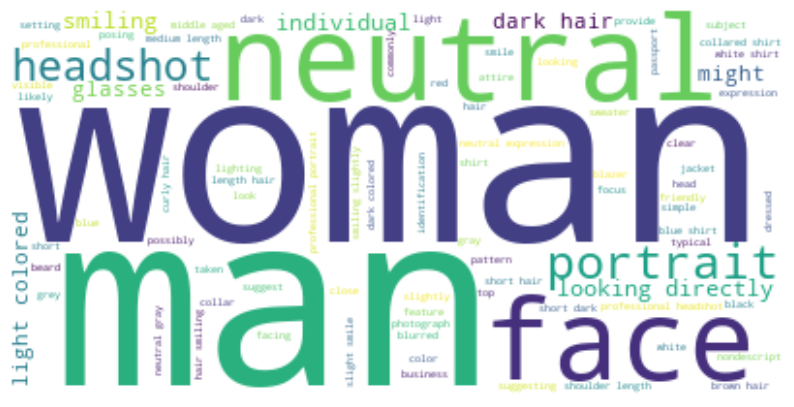

In [145]:

# Start with default stopwords from WordCloud, then add your own
stopwords = set(STOPWORDS)
# Add common prepositions (or any other words you want to exclude)
stopwords.update(['of', 'the', 'and', 'in', 'on', 'at', 'for', 'with', 'without', 
                  'about', 'Error processing photo','Photo not processed','used','seems','plain',
                  'image', 'shows', 'Error processing', 'processed', 'Photo', 'photo', 'wearing', 'seem',
                  'Error', 'processing', 'background','camera','appear','appears', 'person'])

# Combine all text from the 'photo_details' column into one string
# Make sure to drop NaN values to avoid conversion errors
text = ' '.join(detail for detail in df['photo_details'].dropna())

# Generate the word cloud
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)

# Plot the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

# Tarefa 2

Familiarização com a obtenção de dados a partir de packages Python

1. Recorra ao package do wikipedia [https://pypi.org/project/wikipedia/] para criar um
dataset de 2000 imagens relacionadas com duas temáticas distintas à sua escolha
(e.g., covid e desporto)

In [133]:
df.shape

(1379, 9)